# Web Scraping

#### Si vuole fare Web Scraping sul sito di Amazon per fare delle statistiche su un determinato prodotto

## 1. Analisi del DOM ed Estrazione Automatica¶

In [1]:
import requests
from bs4 import BeautifulSoup as soup # serve per analizzare il contenuto della pagina web

page_url = "https://www.amazon.it/s?k=occhiali+da+sole&crid=3NM9B3AU1ARTQ&sprefix=%2Caps%2C111&ref=nb_sb_ss_recent_1_0_recent"

HEADERS = {
    'User-Agent': ('Mozilla/5.0 (X11; Linux x86_64)'
                    'AppleWebKit/537.36 (KHTML, like Gecko)'
                    'Chrome/44.0.2403.157 Safari/537.36'),
    'Accept-Language': 'en-US, en;q=0.5'
}

In [2]:
def scrape_page(page_url, _records = None):
    if _records is None:
        _records = []
    html = requests.get(page_url, headers = HEADERS) # richiesta GET per scaricare il contenuto della pagina
    page_soup = soup(html.text)
    containers = page_soup.findAll('div',{'class':'puis-card-container s-card-container s-overflow-hidden aok-relative puis-expand-height puis-include-content-margin puis puis-vwvhvgkypx2z322f29wcc4lx0s s-latency-cf-section puis-card-border'})
    # 'findAll' restituirà una Resultset di oggetti BeautifulSoup corrispondenti agli elementi trovati che soddisfano i criteri specificati.
    
    for container in containers:
        manufacturer = container.findAll('span',{'class':'a-size-base-plus a-color-base'})[0].text   # nome produttore
        model = container.findAll('span',{'class':'a-size-base-plus a-color-base a-text-normal'})[0].text  # modello 
        img_url = container.findAll('div',{'class':'a-section aok-relative s-image-tall-aspect'})[0].img['src']   # immagine
        try:
            price = container.findAll('span',{'class':'a-price-whole'})[0].text   # prezzo
            price = float(price.replace(',','.'))
        except:
            price = 0
        try:
            review_count = container.findAll('span',{'class':'a-size-base s-underline-text'})[0].text   # numero di recensioni
            review_count = int(review_count.replace('.', ''))
        except:
            review_count = 0
        try:
            rating = container.findAll('span',{'class':'a-icon-alt'})[0].text   # valutazione
            rating = float(rating.replace(' su 5 stelle', '').replace(',', '.'))
        except:
            rating=0
        _records.append([manufacturer, model, img_url, price, review_count, rating])
        
    return _records

In [3]:
import pandas as pd

records = scrape_page(page_url)
data = pd.DataFrame(records, columns=['manufacturer','model','img_url','price','review_count','rating']) # costruisco il DataFrame

In [4]:
data.info()
print("\n\n")
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   manufacturer  0 non-null      object
 1   model         0 non-null      object
 2   img_url       0 non-null      object
 3   price         0 non-null      object
 4   review_count  0 non-null      object
 5   rating        0 non-null      object
dtypes: object(6)
memory usage: 124.0+ bytes





,manufacturer,model,img_url,price,review_count,rating


## 2.1 Download delle Immagini

In [5]:
import os

dest_dir = 'amazon_img'
os.makedirs(dest_dir, exist_ok=True)

In [6]:
import re  # libreria per le espressioni regolari
from os.path import join  # funzione per unire percorsi di directory
from urllib.request import urlretrieve as retrieve  # funzione per scaricare file da un URL

def download_images(data, dest_dir, fname="img_{id:05d}.{ext:s}"):
    data = data.copy()
    data['img_path'] = None  # Crea una nuova colonna 'img_path' nel DataFrame
    
    for i, row in data.iterrows():
        ext = re.search('[^.]+$', row['img_url']).group() # estensione
        fullpath = join(dest_dir, fname.format(id=int(row.name), ext=ext)) # percorso
        retrieve(row['img_url'], fullpath) # scarica l'immagine
        data.at[i, 'img_path'] = fullpath # Aggiungi il percorso al DataFrame usando 'at'

    return data

In [7]:
data2 = download_images(data, 'amazon_img')
data2

,manufacturer,model,img_url,price,review_count,rating,img_path


## 2.2 Navigare Tra le Pagine

In [8]:
p = 1
part1_url = "https://www.amazon.it/s?k=occhiali+da+sole&page="
part2_url = "&crid=FY51CBDZSXMD&qid=1697798329&sprefix=%2Caps%2C106&ref=sr_pg_2"

def navigate_and_scrape(base_url, records = None):
    if records is None:
        records = []
    
    all_records = records
    page = 1 #iniziamo dalla pagina 1
    while(True):
        url = f"{part1_url}{p:d}{part2_url}"
        records = scrape_page(url)
        all_records.extend(records)
        if len(records)==0: #usciamo quando la pagina non contiene più record
            break
        page+=1
    
    return all_records

In [9]:
records = navigate_and_scrape(page_url)
data = pd.DataFrame(records, columns=['manufacturer','model','img_url','price','review_count','rating'])

In [10]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   manufacturer  0 non-null      object
 1   model         0 non-null      object
 2   img_url       0 non-null      object
 3   price         0 non-null      object
 4   review_count  0 non-null      object
 5   rating        0 non-null      object
dtypes: object(6)
memory usage: 124.0+ bytes
None


,manufacturer,model,img_url,price,review_count,rating


## 3 Analisi dei dati ottenuti

In [11]:
data.describe()

,manufacturer,model,img_url,price,review_count,rating
count,0,0,0,0,0,0
unique,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from matplotlib import pyplot as plt # per la costruzione di grafici

#### Distribuzione percentuale dei produttori in base al numero di prodotti (quantità)

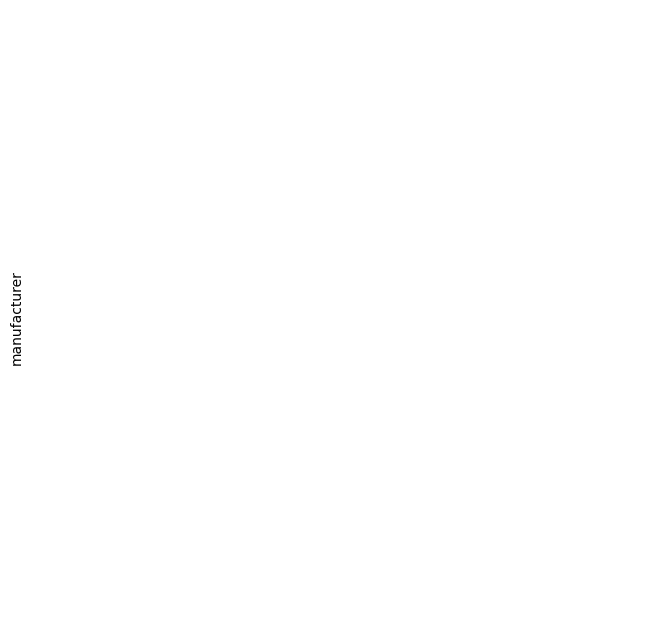

In [13]:
plt.figure(figsize=(8,8)) 
data.groupby('manufacturer')['manufacturer'].count().plot.pie(rotatelabels=True) # crea un grafico a torta 
#data['manufacturer'].value_counts().plot.pie(rotatelabels=True)
#data['manufacturer'].value_counts().plot.bar()
#data['manufacturer'].value_counts().plot.line()
#data.plot.scatter(x='price', y='rating')
#data.boxplot(column='price', by='manufacturer')
#data['price'].plot.hist()
#data.plot.area()
plt.show()

#### Media dei prezzi dei prodotti per ciascun produttore (costo)

TypeError: no numeric data to plot

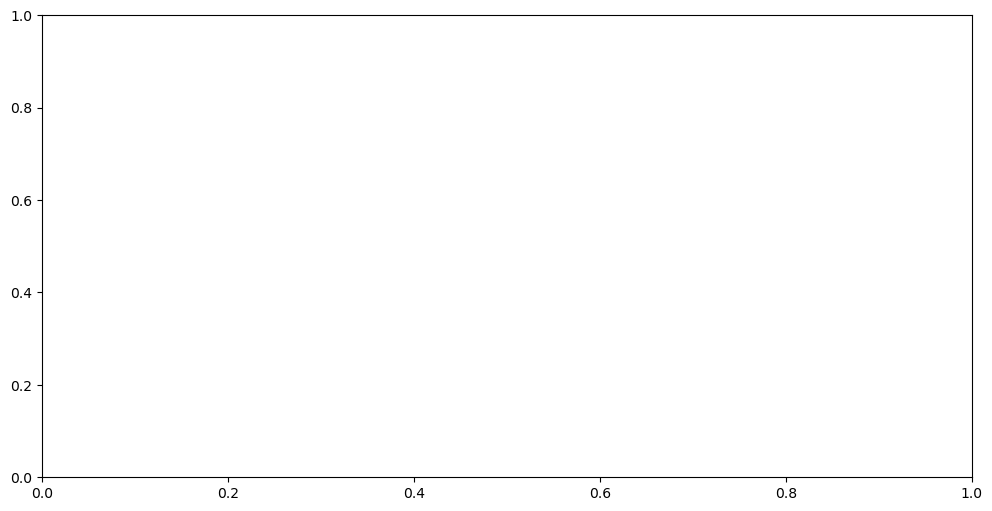

In [14]:
plt.figure(figsize=(12,6))
data.groupby('manufacturer')['price'].mean().plot.bar() # crea un grafico a barre verticali
plt.grid()
plt.show()

#### Somma del numero di recensioni per ogni produttore (popolarità)

In [ ]:
plt.figure(figsize=(12,6))
data.groupby('manufacturer')['review_count'].sum().plot.bar()
plt.grid()
plt.show()

#### Valutazioni (rating) medie dei prodotti in base ai produttori.

In [ ]:
plt.figure(figsize=(12,6))
data.groupby('manufacturer')['rating'].mean().plot.bar()
plt.grid()
plt.show()

#### Media delle valutazioni per il produttore LOPKJ (valutazione media più bassa)

In [ ]:
mask1 = data['manufacturer']=='LOPKJ'

plt.figure(figsize=(12,6))
data[mask1].groupby('manufacturer')['rating'].mean().plot.bar()
plt.grid()
plt.show()